POTATO DISEASE LEAF

`01` Import Libraries 

In [8]:
import pandas as pd  
import numpy as  np  
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from numpy import random

import seaborn as sns
%matplotlib inline

In [9]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# import the l2
from tensorflow.keras.regularizers import l2



`02` Global Variables

In [10]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

EPOCHS = 20

NUM_SAMPLES = 4

`03` Read Data

In [11]:
data_dir = '/home/israa/Desktop/Computer_Vision_Projects/01-Potato_Disease_Leaf/PLD_3_Classes_256'

# Update train_dir to use an absolute path
early_bight_path = healthy_bath = os.path.join(data_dir, 'Training/Early_Blight')
healthy_bath = os.path.join(data_dir, 'Training/Healthy')
late_bight_path = os.path.join(data_dir, 'Training/Late_Blight')

early_train_files = [os.path.join(early_bight_path, filename) for filename in os.listdir(early_bight_path)]
healthy_train_files = [os.path.join(healthy_bath, filename) for filename in os.listdir(healthy_bath)]
late_train_files = [os.path.join(late_bight_path, filename) for filename in os.listdir(late_bight_path)]


`04` Simple EDA

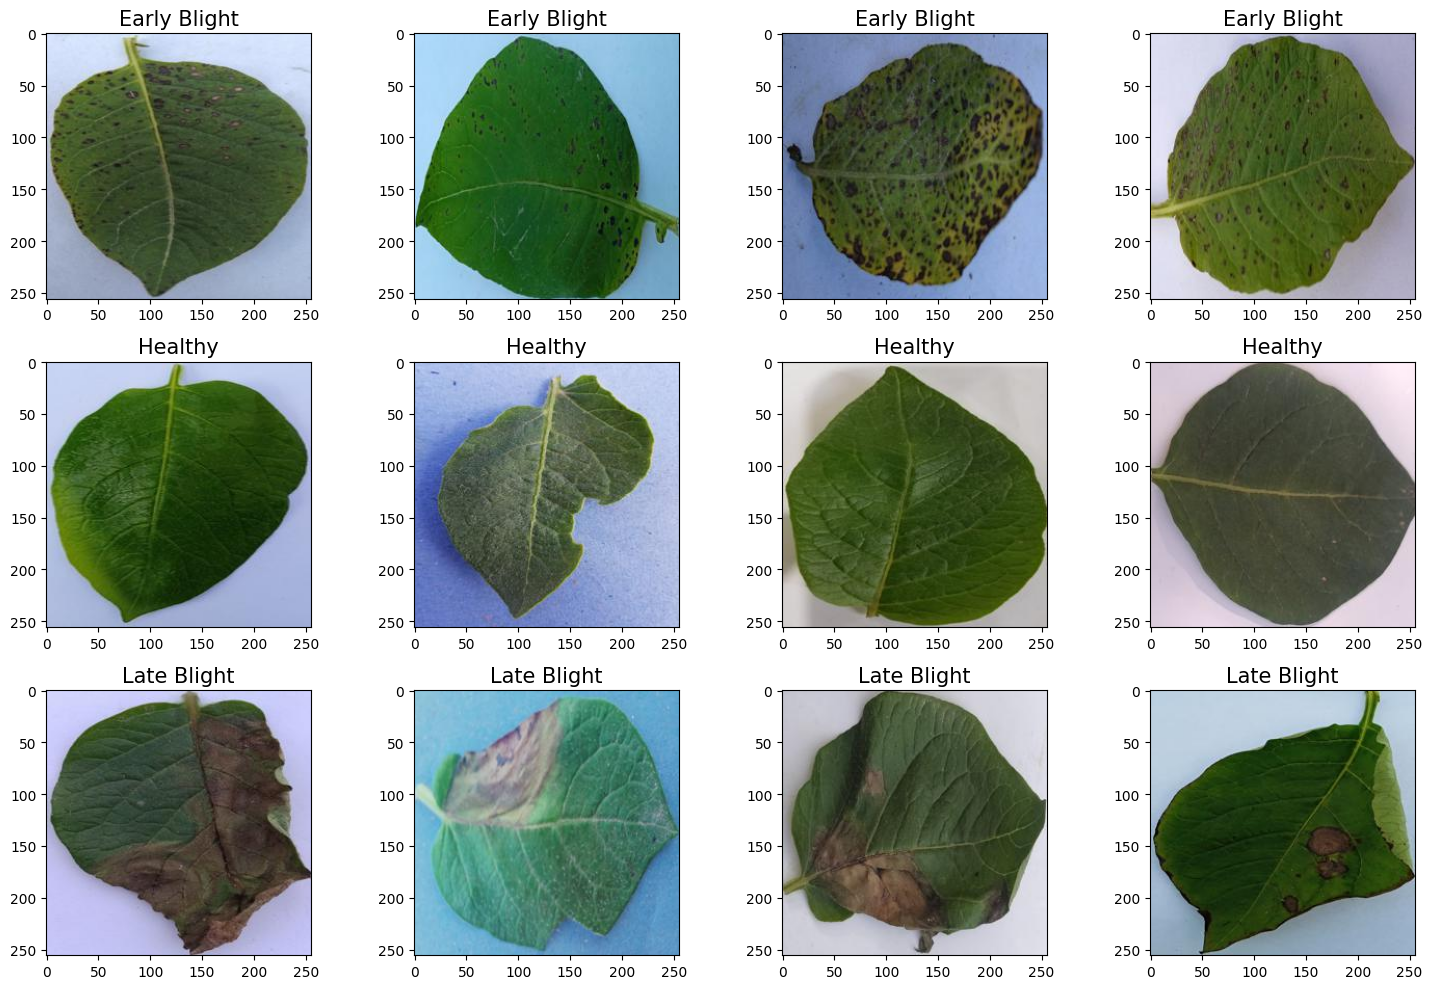

In [12]:
# Create subplots for displaying images
fig, axes = plt.subplots(3, NUM_SAMPLES, figsize=(15, 10))

# Displaying Early Blight images
early_sample = random.choice(early_train_files, NUM_SAMPLES, replace=False)
for i, image_path in enumerate(early_sample):
    ax = axes[0, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Early Blight', fontsize=15)  
    ax.axis('on')  # Show axis


# Displaying Healthy images
healthy_sample = random.choice(healthy_train_files, NUM_SAMPLES, replace=False)
for i, image_path in enumerate(healthy_sample):
    ax = axes[1, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Healthy', fontsize=15)  
    ax.axis('on')  # Show axis

# Displaying Late Blight images
late_sample = random.choice(late_train_files, NUM_SAMPLES, replace=False)
for i, image_path in enumerate(late_sample):
    ax = axes[2, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Late Blight', fontsize=15)  
    ax.axis('on')  # Show axis


plt.tight_layout()  

`05` Preprocessing

### Rescaling Images for Better Training Performance

Rescaling the images by dividing pixel values by 255 (i.e., `rescale=1./255`) is a **normalization** technique that helps simplify the image matrices.

### Why is this helpful?

*   **Pixel Value Range**: The original pixel values in an image range from 0 to 255. By dividing by 255, you're scaling the pixel values to a range between **0 and 1**.
    
*   **Improved Model Training**: Neural networks generally perform better and converge faster when the input data is normalized, because:
    
    *   It helps the optimizer converge more quickly (gradient descent works better with smaller, consistent values).
        
    *   It reduces the risk of numerical instability during training.
        
    *   It makes training more efficient by ensuring that each input feature (pixel) has similar scales.

### In Short:

*   **Rescaling** doesn't "simplify" the images in terms of content, but it **simplifies the data** by making the numerical values more manageable and consistent. This leads to **faster training** and **more stable training dynamics**.


In [13]:
# 1. Create ImageDataGenerator objects for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# 2. Create generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Training'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(os.path.join(data_dir, 'Validation'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(os.path.join(data_dir, 'Testing'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [56]:
# 3. Check the class indices
print("Class Index Mapping:", train_generator.class_indices)

# 4. Check the number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

# 5. Check the number of samples in each generator
print("Number of training samples:", len(train_generator.filenames))
print("Number of validation samples:", len(valid_generator.filenames))
print("Number of testing samples:", len(test_generator.filenames))


Class Index Mapping: {'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}
Number of classes: 3
Number of training samples: 3251
Number of validation samples: 416
Number of testing samples: 405


In [57]:
# 6. Check the shape of the images
sample_image, sample_label = next(train_generator)
print("Shape of sample image:", sample_image.shape)

# 7. Check the shape of the labels
print("Shape of sample label:", sample_label.shape)

# The sample is the size of the batch, which is 32 in this case.

Shape of sample image: (32, 128, 128, 3)
Shape of sample label: (32, 3)


In [58]:
# 8. Check the class distribution in the training set
class_counts = np.bincount(train_generator.classes)
class_distribution = dict(zip(train_generator.class_indices.keys(), class_counts))
print("Class distribution in training set:", class_distribution)


Class distribution in training set: {'Early_Blight': 1303, 'Healthy': 816, 'Late_Blight': 1132}


`06` Data Visualization 

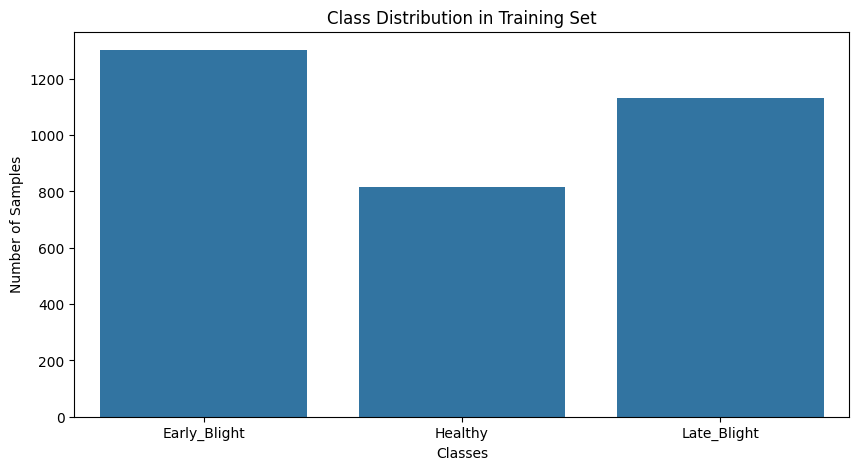

In [59]:
# 9. Visualize the class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

The data is quiete balanced

remember that we have used a generator for the train data 

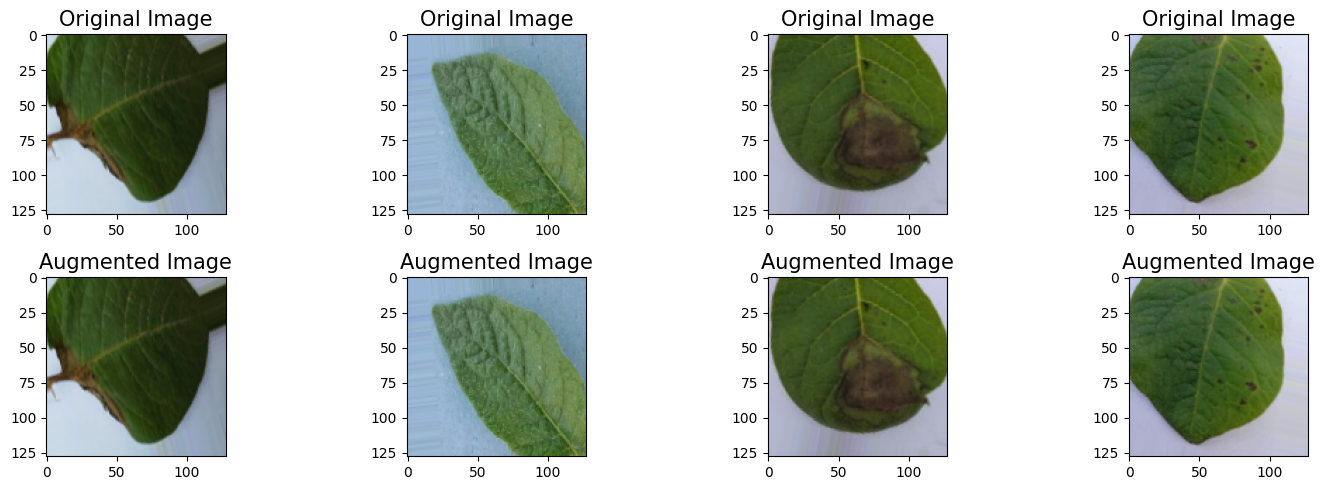

In [60]:
# 10. Visualize some augmented images vs original images
sample_images, sample_labels = next(train_generator)

# Create subplots for displaying images
fig, axes = plt.subplots(2, NUM_SAMPLES, figsize=(15, 5))

# Displaying original images
for i in range(NUM_SAMPLES):
    ax = axes[0, i]
    img = sample_images[i]
    ax.imshow(img)
    ax.set_title('Original Image', fontsize=15)  
    ax.axis('on')  # Show axis

# Displaying augmented images
for i in range(NUM_SAMPLES):
    ax = axes[1, i]
    img = sample_images[i]
    ax.imshow(img)
    ax.set_title('Augmented Image', fontsize=15)  
    ax.axis('on')  # Show axis

plt.tight_layout()


`07` Model 

`07.1` Pretrained model

In [80]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.8316705039652085, 1: 1.3280228758169934, 2: 0.9573027090694936}


In [81]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.4)(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_30        │ (None, 128, 128,  │          0 │ input_layer_15[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_15    │ (None, 128, 128,  │          7 │ rescaling_30[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_31        │ (None, 128, 128,  │          0 │ normalization_15… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_31[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,706,982 (17.96 MB)

 Trainable params: 4,664,959 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
]

In [84]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8095 - loss: 5.0514
Epoch 1: val_loss improved from inf to 5.86853, saving model to best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 69s 327ms/step - accuracy: 0.8103 - loss: 5.0317 - val_accuracy: 0.2452 - val_loss: 5.8685 - learning_rate: 0.0010
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9565 - loss: 0.4434
Epoch 2: val_loss improved from 5.86853 to 4.12921, saving model to best_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9565 - loss: 0.4424 - val_accuracy: 0.2452 - val_loss: 4.1292 - learning_rate: 0.0010
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9636 - loss: 0.2181
Epoch 3: val_loss did not improve from 4.12921
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9636 - loss: 0.2180 - val_accuracy: 0.2452 - val_loss: 5.3265 - learning_rate: 0.0010
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9622 - loss: 0.1710
Epoch 4: 

In [70]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

print("Train Loss:", history.history['loss'][-1])
print("Train Accuracy:", history.history['accuracy'][-1])

print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.9854 - loss: 0.0829
Test Loss: 0.05397796630859375
Test Accuracy: 0.990123450756073


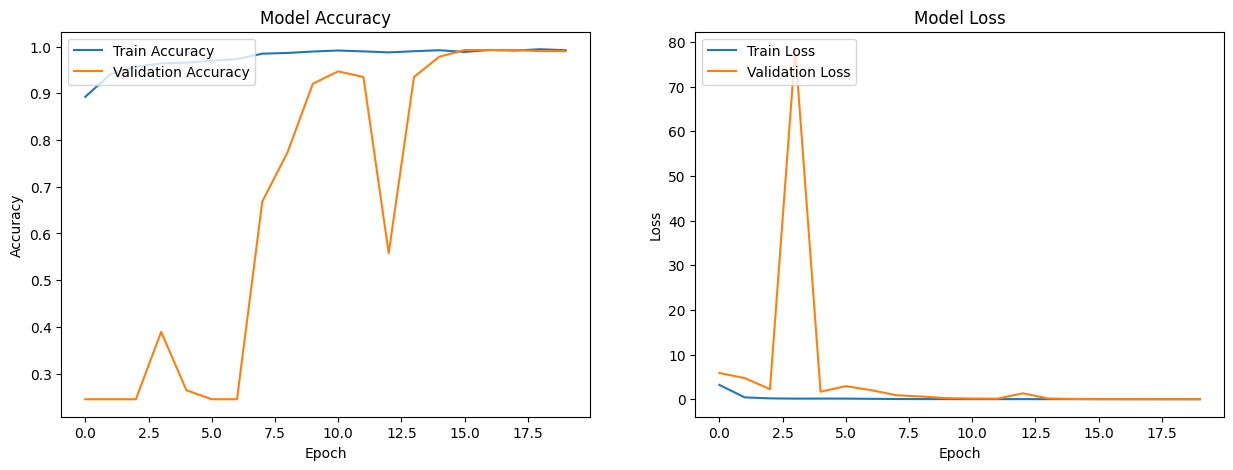

In [72]:
# Plot training & validation accuracy values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper left')
# Plot training & validation loss values
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper left')
plt.show()


In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')
# Make predictions on the test set
test_generator.reset()
predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)
# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)
# Get the true class indices
true_classes = test_generator.classes
# Get the class labels
class_labels = list(test_generator.class_indices.keys())
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


`07.2` Creating CNN model

In [26]:

# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# import os
# import cv2
# import random
# import numpy as np
# import pandas as pd
# from PIL import Image
# # from skimage import exposure
# from sklearn.utils import shuffle
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import tensorflow as tf
# # import keras_tuner
# from keras import Sequential
# from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization,InputLayer
# from tensorflow import keras
# from keras import Sequential
# from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import warnings
# warnings.filterwarnings('ignore')



# model = Sequential()

# model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',input_shape=(128,128,3),kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D(pool_size=(2,2),strides=2,padding='same'))

# model.add(Conv2D(164,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D(pool_size=(2,2),strides=2,padding='same'))

# model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D(pool_size=(2,2),strides=2,padding='same'))

# model.add(Flatten())

# model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Dense(3,activation='softmax'))

# from tensorflow.keras.optimizers import Adadelta
# optimizer = Adadelta(learning_rate=1.0, rho=0.95)


# model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# CALLBACKS = [early_stopping_cb]
# history = model.fit(
#     train_generator,
#     callbacks=CALLBACKS,
#     epochs=100,
#     validation_data=valid_generator
# )


In [27]:
# model.summary()

In [28]:
# accuracy, loss = model.evaluate(test_generator)

# print("Test Accuracy:", accuracy)
# print("Test Loss:", loss)

In [29]:
# pd.DataFrame(history.history).plot()